In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [9]:
# Load the temperature data
dd=pd.read_csv('Baltimore 2023-01-01 to 2024-12-31.csv')
dd['T']=(dd['tempmax']+dd['tempmin'])/2
temps1=dd[dd['datetime']<'2024-01-01']['T'].values
temps2=dd[dd['datetime']>'2024-01-01']['T'].values[:365]
dd

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations,T
0,Baltimore,2023-01-01,62.5,41.9,51.1,62.5,41.1,50.7,43.6,78.5,...,5,NaN,2023-01-01T07:26:20,2023-01-01T16:53:51,0.32,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"KDMW,99999913752,C1550,72406093721,72069903724...",52.20
1,Baltimore,2023-01-02,63.3,39.5,48.9,63.3,39.5,48.9,42.9,80.8,...,4,NaN,2023-01-02T07:26:27,2023-01-02T16:54:40,0.35,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDMW,99999913752,C1550,72406093721,72069903724...",51.40
2,Baltimore,2023-01-03,65.7,45.3,55.2,65.7,45.3,55.2,49.6,82.1,...,2,NaN,2023-01-03T07:26:32,2023-01-03T16:55:31,0.39,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDMW,99999913752,C1550,72406093721,72069903724...",55.50
3,Baltimore,2023-01-04,62.5,51.8,59.8,62.5,51.8,59.8,55.0,84.3,...,2,NaN,2023-01-04T07:26:35,2023-01-04T16:56:24,0.42,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDMW,99999913752,C1550,72405713701,72406093721...",57.15
4,Baltimore,2023-01-05,62.2,49.7,55.9,62.2,47.9,55.8,46.4,72.2,...,3,NaN,2023-01-05T07:26:35,2023-01-05T16:57:18,0.46,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"KDMW,99999913752,72405713701,C1550,72406093721...",55.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,Baltimore,2024-12-27,43.9,29.8,38.0,42.0,29.1,36.5,29.0,70.2,...,5,10.0,2024-12-27T07:25:23,2024-12-27T16:50:27,0.90,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDMW,C1550,72405713701,72406093721,72069903724...",36.85
727,Baltimore,2024-12-28,48.7,39.6,44.0,48.7,39.6,43.7,42.6,94.8,...,1,10.0,2024-12-28T07:25:40,2024-12-28T16:51:10,0.93,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"KDMW,C1550,72406093721,72069903724,KBWI,724067...",44.15
728,Baltimore,2024-12-29,62.2,47.2,54.3,62.2,46.6,54.2,50.8,88.7,...,5,10.0,2024-12-29T07:25:54,2024-12-29T16:51:54,0.96,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"KDMW,C1550,72406093721,72069903724,KBWI,724067...",54.70
729,Baltimore,2024-12-30,60.3,43.2,53.7,60.3,41.1,53.1,38.9,60.7,...,5,10.0,2024-12-30T07:26:07,2024-12-30T16:52:40,0.00,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"KDMW,C1550,72405713701,72406093721,72069903724...",51.75


In [ ]:
### fit seasonal model to get parameters for OU model

dates = dd[dd['datetime']<'2024-01-01']["datetime"]
n = len(temps1)

# Step 1: Fit seasonal model T_seasonal(t) = a0 + a1*sin(...) + a2*cos(...)
t = np.arange(n)  # time index in days

# Design matrix for least squares fit
X = np.column_stack([
    np.ones(n),
    np.sin(2 * np.pi * t / 365),
    np.cos(2 * np.pi * t / 365)
])

# Least squares fit: solve X * beta = temps
beta_hat = np.linalg.lstsq(X, temps1, rcond=None)[0]
a0, a1, a2 = beta_hat

# Compute seasonal trend
T_seasonal = X @ beta_hat

# Step 2: Compute residuals
T_resid = temps1 - T_seasonal

# Step 3: Fit OU model to residuals
def OU_calibrate_ls(S, delta=1.0):
    n = len(S) - 1
    Sx = np.sum(S[:-1])
    Sy = np.sum(S[1:])
    Sxx = np.sum(S[:-1] ** 2)
    Sxy = np.sum(S[:-1] * S[1:])
    Syy = np.sum(S[1:] ** 2)

    a = (n * Sxy - Sx * Sy) / (n * Sxx - Sx ** 2)
    b = (Sy - a * Sx) / n
    sd = np.sqrt((n * Syy - Sy ** 2 - a * (n * Sxy - Sx * Sy)) / (n * (n - 2)))

    lam = -np.log(a) / delta
    mu = b / (1 - a)
    sigma = sd * np.sqrt((-2 * np.log(a)) / (delta * (1 - a ** 2)))

    return mu, sigma, lam

mu_hat, sigma_hat, lambda_hat = OU_calibrate_ls(T_resid)

print(f"OU calibration on residuals:")
print(f"Estimated μ: {mu_hat:.4f}")
print(f"Estimated σ: {sigma_hat:.4f}")
print(f"Estimated λ: {lambda_hat:.6f}")




OU calibration on residuals:
Estimated μ: -0.0630
Estimated σ: 5.7612
Estimated λ: 0.431793


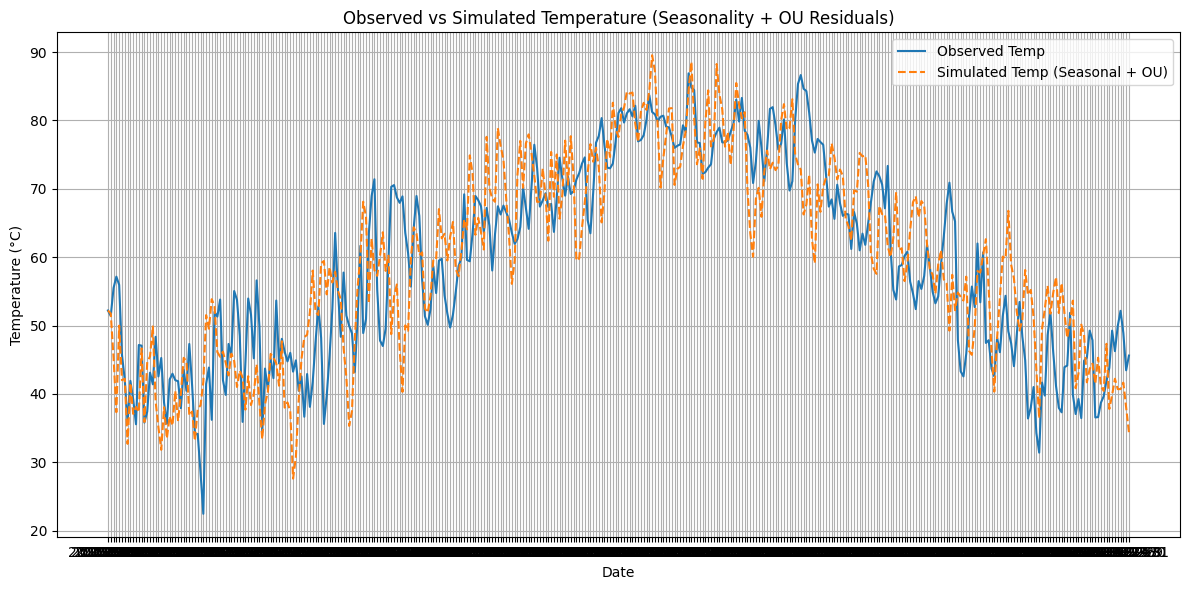

In [ ]:
### check the the model
delta = 1.0
T_sim_resid = [T_resid[0]]
Z = np.random.normal(0, 1, len(T_resid))

for i in range(n - 1):
    prev = T_sim_resid[-1]
    exp_term = np.exp(-lambda_hat * delta)
    mean_term = mu_hat * (1 - exp_term)
    std_term = sigma_hat * np.sqrt((1 - np.exp(-2 * lambda_hat * delta)) / (2 * lambda_hat))
    T_sim_resid.append(prev * exp_term + mean_term + std_term * Z[i])

T_sim_resid = np.array(T_sim_resid)

# Step 5: Add seasonal back to simulated residuals
T_sim_full = T_seasonal + T_sim_resid

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, temps1, label="Observed Temp")
plt.plot(dates, T_sim_full, "--", label="Simulated Temp (Seasonal + OU)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Observed vs Simulated Temperature (Seasonality + OU Residuals)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

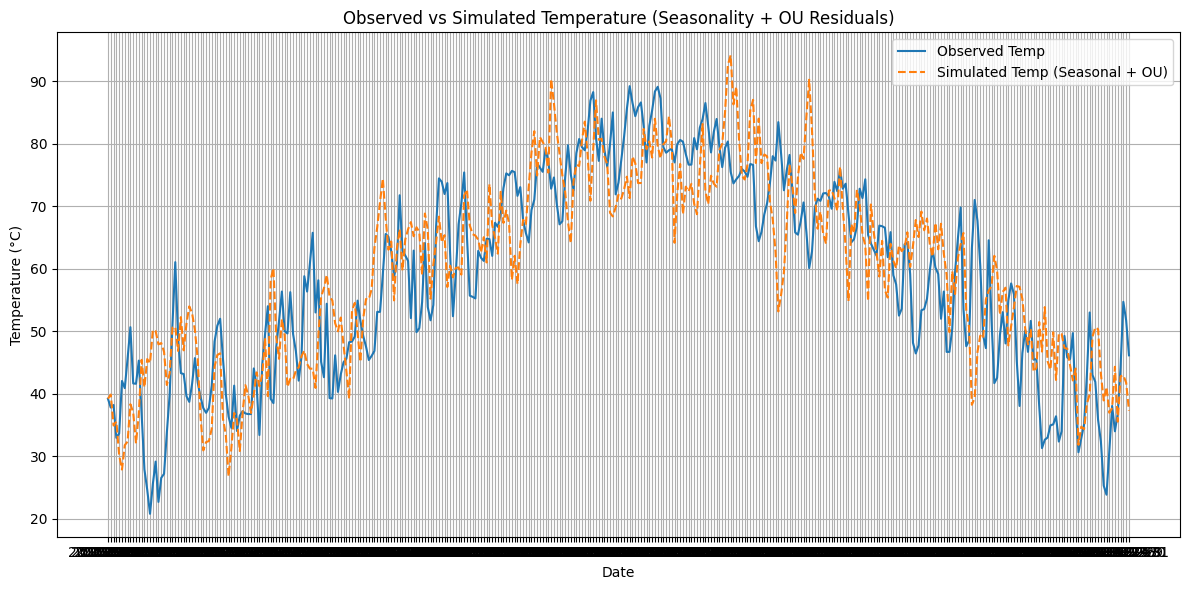

In [ ]:
### check model simulation performance
dates2 = dd[dd['datetime']>'2024-01-01']["datetime"]

# Design matrix for least squares fit
X = np.column_stack([
    np.ones(n),
    np.sin(2 * np.pi * t / 365),
    np.cos(2 * np.pi * t / 365)
])

# Least squares fit: solve X * beta = temps
beta_hat = np.linalg.lstsq(X, temps2, rcond=None)[0]
a0, a1, a2 = beta_hat

# Compute seasonal trend
T_seasonal = X @ beta_hat

# Step 2: Compute residuals
T_resid2 = temps2 - T_seasonal
delta = 1.0
T_sim_resid = [T_resid2[0]]
Z = np.random.normal(0, 1, len(T_resid2))

for i in range(n - 1):
    prev = T_sim_resid[-1]
    exp_term = np.exp(-lambda_hat * delta)
    mean_term = mu_hat * (1 - exp_term)
    std_term = sigma_hat * np.sqrt((1 - np.exp(-2 * lambda_hat * delta)) / (2 * lambda_hat))
    T_sim_resid.append(prev * exp_term + mean_term + std_term * Z[i])

T_sim_resid = np.array(T_sim_resid)

# Step 5: Add seasonal back to simulated residuals
T_sim_full = T_seasonal + T_sim_resid

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, temps2, label="Observed Temp")
plt.plot(dates, T_sim_full, "--", label="Simulated Temp (Seasonal + OU)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Observed vs Simulated Temperature (Seasonality + OU Residuals)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

T_resid2 = temps2 - T_seasonal
delta = 1.0
T_sim_resid = [T_resid2[0]]
Z = np.random.normal(0, 1, len(T_resid2))

for i in range(n - 1):
    prev = T_sim_resid[-1]
    exp_term = np.exp(-lambda_hat * delta)
    mean_term = mu_hat * (1 - exp_term)
    std_term = sigma_hat * np.sqrt((1 - np.exp(-2 * lambda_hat * delta)) / (2 * lambda_hat))
    T_sim_resid.append(prev * exp_term + mean_term + std_term * Z[i])

T_sim_resid = np.array(T_sim_resid)

# Step 5: Add seasonal back to simulated residuals
T_sim_full = T_seasonal + T_sim_resid

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, temps2, label="Observed Temp")
plt.plot(dates, T_sim_full, "--", label="Simulated Temp (Seasonal + OU)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Observed vs Simulated Temperature (Seasonality + OU Residuals)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# check the performance of the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#used temps2 for observed temperature:
obs = temps2
sim = T_sim_full
sim=T_seasonal

# Metrics
mbe = np.mean(sim - obs)
rmse = np.sqrt(mean_squared_error(obs, sim))
mae = mean_absolute_error(obs, sim)
r2 = r2_score(obs, sim)

print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Bias Error (MBE): 0.3071
Root Mean Square Error (RMSE): 7.0521
Mean Absolute Error (MAE): 5.6351
R-squared (R²): 0.8130
